In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from copy import deepcopy

from tqdm import tqdm



/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot NIPS

In [109]:
#functions
def split_metric_test_train(metric):
    metric_name = metric.strip().split(':')[0]
    test_train = metric.strip().split(':')[1].strip().strip(')').split('(')
    test = float(test_train[0].strip())
    train = float(test_train[1].strip())
    # print(metric_name, test, train)
    return test, train, metric_name


def split_metric(metric):
    metric_name = metric.strip().split(':')[0]
    test = metric.strip().split(':')[1].strip()
    test = float(test)
    return test, metric_name

def udpate_list_dict(key, value, dict_={}):
    if key not in dict_.keys():
        dict_[key] = []
    dict_[key] += [value]
    return dict_ 

# for chat GPT
def form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time):
    data_dict = {}
    data_dict['MSE_test'] = np.asarray(mse)[:,0].tolist()
    data_dict['MSE_train'] = np.asarray(mse)[:,1].tolist()
    data_dict['PSNR_test'] = np.asarray(psnr)[:,0].tolist()
    data_dict['PSNR_train'] = np.asarray(psnr)[:,1].tolist()
    data_dict['Rec FID_test'] = np.asarray(rec_fid)[:,0].tolist()
    data_dict['Rec FID_train'] = np.asarray(rec_fid)[:,1].tolist()
    data_dict['FID gm1'] = fid_gm1
    data_dict['FID gm4'] = fid_gm4
    data_dict['Mean epoch time'] = mean_epoch_time
    data_dict['model_type'] = model_type

    x_list = dimensions
    return data_dict, x_list


def form_data_from_strings(str_paired_metrics, str_single_metrics, model_type):
    data_dict = {}

    lines = str_paired_metrics.strip().split('\n')
    for line in lines:
        metrics = line.strip().split(';')
        for i, metric in enumerate(metrics):
            test, train, metric_name = split_metric_test_train(metric)
            key = metric_name+'_train'
            udpate_list_dict( metric_name+'_test', test, dict_=data_dict)
            udpate_list_dict( metric_name+'_train', train, dict_=data_dict)
    
    lines = str_single_metrics.strip().split('\n')       
    for line in lines:
        metrics = line.strip().split(';')
        for i, metric in enumerate(metrics):
            value, metric_name = split_metric(metric)
            udpate_list_dict( metric_name, value, dict_=data_dict)
            # udpate_list_dict( metric_name+'_train', train, dict_=data_dict)       
            
            
    data_dict['model_type'] = model_type
    return data_dict


def process_metrices_file(file_path, extract_x_fun, name_line=0, rec_start_end_line=[2, 4], fid_line=-1):
    # I can add sort (maybe not necessary) 
    # I can add other metrics or recognize metrics by the reg_exp
    with open(file_path, 'r') as f:
        str_file = f.read()
    exp_results = [exp_result for exp_result in str_file.split('\n\n') if (exp_result != '') or (exp_result != '') ]

    x_list = []
    str_rec_metrics = ''
    str_gen_fid = ''
    for i in range(len(exp_results)):
        exp_result = exp_results[i].strip().strip('\n')
        # print(exp_result, end='\n\n')
        str_rec_metrics += ''.join(exp_result.split('\n')[rec_start_end_line[0]:rec_start_end_line[1]]) + '\n'
        str_gen_fid += exp_result.split('\n')[fid_line] + '\n'
        exp_name = exp_result.split('\n')[name_line].strip().split(' ')[-1].split('/')[-1].strip()
        x_list += [extract_x_fun(exp_name)]
    return str_rec_metrics, str_gen_fid, x_list



def sort_strs_by_list(str_, list_, str_sep='\n'):
    yx = list(zip(list_, str_.split(str_sep)))
    yx.sort()
    return str_sep.join([x for y, x in yx])


def sort_strings(x_list, strings_list, str_sep='\n'):
    x_list = deepcopy(x_list)
    sorted_string_list = []
    for string in strings_list:
        sorted_string_list += [sort_strs_by_list(string, x_list, str_sep=str_sep)]
    x_list.sort()
    return [x_list] + sorted_string_list
    
    
def drop_lines(string, i_drop_list, str_sep='\n'):
    if not isinstance(i_drop_list, (list, tuple)):
        i_drop_list = [i_drop_list]
    i_drop_list.sort()
    
    lines = string.split(str_sep)
    for i_drop in i_drop_list[::-1]:
        lines.pop(i_drop)
    return str_sep.join(lines)

def drop_lines_from_strings(string_list, i_drop_list, str_sep='\n'):
    if not isinstance(string_list, (list, tuple)):
        string_list = [string_list]
        
    out_string_list = []
    for string in string_list:
        out_string_list += [drop_lines(string, i_drop_list, str_sep=str_sep)]
    return out_string_list
            
            
            
        
        
        
        
        
    
    




In [52]:
a = [0, 1, 2, 3, 4, 5]
a.pop(2)

2

In [100]:
a[::-1]

[7, 6, 5, 4, 3, 2, 1, 0]

## MNIST

### alpha

In [2]:
model_type = 'VAE'
str_rec_metrics = """
MSE: 0.0213(0.0212);   PSNR: 16.73 (16.73);   Rec FID: 32.15 (31.16)
MSE: 0.0086(0.0083);   PSNR: 20.65 (20.80);   Rec FID: 11.07 (10.34)
MSE: 0.0042(0.0039);   PSNR: 23.81 (24.04);   Rec FID: 8.99 (8.28)
MSE: 0.0022(0.0021);   PSNR: 26.50 (26.84);   Rec FID: 7.18 (6.51)
"""
str_gen_fid  = """
FID gm1: 59.33;   FID gm4: 43.61
FID gm1: 34.59;   FID gm4: 21.20
FID gm1: 31.29;   FID gm4: 17.89
FID gm1: 36.97;   FID gm4: 21.81
"""
alpha_list = [1/(10**(i+1)) for i in range(4)]


model_type = 'LRAE'
str_rec_metrics = """
MSE: 0.0035(0.0033);  PSNR: 24.60 (24.76);    Rec FID: 8.50 (7.83)
MSE: 0.0024(0.0023);   PSNR: 26.17 (26.48);   Rec FID: 7.97 (7.31)
MSE: 0.0031(0.0028);   PSNR: 25.05 (25.54);   Rec FID: 7.99 (7.32)
MSE: 0.0036(0.0033);   PSNR: 24.42 (24.75);   Rec FID: 8.08 (7.49)
"""
str_gen_fid  = """
FID gm1: 27.79;   FID gm4: 16.51
FID gm1: 31.39;   FID gm4: 18.98
FID gm1: 30.92;   FID gm4: 18.16
FID gm1: 32.37;   FID gm4: 19.47
"""
x_list = [3.2, 1, 0.5] +  [1/(10**(i+1)) for i in range(4)]
x_label = 'alpha'

print(x_list)

[3.2, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]


### batch size

In [3]:
model_type = 'VAE'
str_rec_metrics = """
MSE: 0.0042(0.0039); PSNR: 23.81 (24.04);   Rec FID: 8.99 (8.28)
MSE: 0.0045 (0.0043);   PSNR: 23.47 (23.62);   Rec FID: 9.03 (8.39)
MSE: 0.0049 (0.0048);   PSNR: 23.11 (23.18);   Rec FID: 9.13 (8.51)
MSE: 0.0058 (0.0057);   PSNR: 22.40 (22.42);   Rec FID: 10.08 (9.51)
MSE: 0.0069 (0.0070);   PSNR: 21.59 (21.56);   Rec FID: 11.73 (11.32)
"""
str_gen_fid  = """
FID gm1: 31.29; FID gm4: 17.89
FID gm1: 32.75;   FID gm4: 19.90
FID gm1: 36.48;   FID gm4: 21.03
FID gm1: 37.33;   FID gm4: 24.63
FID gm1: 41.17;   FID gm4: 27.53
"""

x_label = 'batch_size'

x_list = [32, 128, 256, 512, 1024]


print(x_list)

[32, 128, 256, 512, 1024]


### epoch

In [27]:
model_type = 'VAE 1024 1e-4'
str_rec_metrics = """
MSE: 0.0069 (0.0069);   PSNR: 21.63 (21.60);   Rec FID: 11.38 (11.08)
MSE: 0.0060 (0.0060);   PSNR: 22.24 (22.25);   Rec FID: 10.40 (9.83)
MSE: 0.0054 (0.0053);   PSNR: 22.67 (22.74);   Rec FID: 9.66 (9.16)
MSE: 0.0051 (0.0050);   PSNR: 22.92 (23.02);   Rec FID: 9.35 (8.79)
MSE: 0.0049 (0.0047);   PSNR: 23.11 (23.26);   Rec FID: 9.26 (8.64)
MSE: 0.0047 (0.0045);   PSNR: 23.32 (23.49);   Rec FID: 9.07 (8.44)
MSE: 0.0045 (0.0044);   PSNR: 23.43 (23.59);   Rec FID: 8.93 (8.30)
"""
str_gen_fid  = """
FID gm1: 40.82;   FID gm4: 27.93
FID gm1: 38.59;   FID gm4: 23.64
FID gm1: 36.98;   FID gm4: 22.14
FID gm1: 36.04;   FID gm4: 22.17
FID gm1: 36.82;   FID gm4: 23.11
FID gm1: 34.46;   FID gm4: 19.38
FID gm1: 34.45;   FID gm4: 21.98
"""

x_label = 'epoch'
x_list = [50 + i*25 for i in range(7)]
x_list

[50, 75, 100, 125, 150, 175, 200]

In [23]:
model_type = 'VAE  1024 5.7*1e-4'
str_rec_metrics = """
MSE: 0.0064 (0.0064);   PSNR: 21.95 (21.97);   Rec FID: 10.90 (10.38)
MSE: 0.0052 (0.0050);   PSNR: 22.87 (22.99);   Rec FID: 10.08 (9.35)
MSE: 0.0048 (0.0046);   PSNR: 23.22 (23.41);   Rec FID: 9.54 (8.85)
MSE: 0.0045 (0.0043);   PSNR: 23.46 (23.71);   Rec FID: 9.18 (8.56)
MSE: 0.0043 (0.0040);   PSNR: 23.67 (23.98);   Rec FID: 9.28 (8.62)
MSE: 0.0043 (0.0039);   PSNR: 23.71 (24.06);   Rec FID: 9.15 (8.42)
MSE: 0.0041 (0.0037);   PSNR: 23.89 (24.26);   Rec FID: 9.21 (8.45)
MSE: 0.0041 (0.0037);   PSNR: 23.87 (24.29);   Rec FID: 9.10 (8.35)
"""
str_gen_fid  = """
FID gm1: 35.88;   FID gm4: 22.24
FID gm1: 35.93;   FID gm4: 22.37
FID gm1: 34.54;   FID gm4: 22.82
FID gm1: 34.89;   FID gm4: 20.19
FID gm1: 32.73;   FID gm4: 18.62
FID gm1: 33.10;   FID gm4: 18.40
FID gm1: 32.76;   FID gm4: 18.27
FID gm1: 32.58;   FID gm4: 17.69
"""

x_label = 'epoch'
x_list = [25 + i*25 for i in range(8)]
x_list

[25, 50, 75, 100, 125, 150, 175, 200]

In [17]:
model_type = 'VAE  1024 32*1e-4'
str_rec_metrics = """
MSE: 0.0073 (0.0072);   PSNR: 21.40 (21.45);   Rec FID: 10.96 (10.49)
MSE: 0.0060 (0.0058);   PSNR: 22.21 (22.35);   Rec FID: 9.53 (9.04)
MSE: 0.0055 (0.0052);   PSNR: 22.57 (22.80);   Rec FID: 9.08 (8.41)
MSE: 0.0053 (0.0050);   PSNR: 22.75 (23.02);   Rec FID: 9.02 (8.37)
MSE: 0.0053 (0.0049);   PSNR: 22.78 (23.09);   Rec FID: 9.17 (8.51)
MSE: 0.0051 (0.0047);   PSNR: 22.90 (23.24);   Rec FID: 8.75 (7.99)
MSE: 0.0049 (0.0046);   PSNR: 23.06 (23.42);   Rec FID: 8.83 (8.08)
MSE: 0.0049 (0.0044);   PSNR: 23.12 (23.53);   Rec FID: 8.75 (8.01)
"""
str_gen_fid  = """
FID gm1: 38.94;   FID gm4: 25.00
FID gm1: 38.46;   FID gm4: 23.90
FID gm1: 36.53;   FID gm4: 23.71
FID gm1: 36.72;   FID gm4: 20.16
FID gm1: 37.13;   FID gm4: 22.62
FID gm1: 34.52;   FID gm4: 20.09
FID gm1: 36.13;   FID gm4: 21.50
FID gm1: 35.85;   FID gm4: 20.66
"""

x_label = 'epoch'
x_list = [25 + i*25 for i in range(8)]
x_list

[25, 50, 75, 100, 125, 150, 175, 200]

### n_latent

In [19]:
model_type = 'AE  256 1e-4 n_latent'
str_rec_metrics = """
MSE: 0.0399 (0.0392);   PSNR: 13.99 (14.06);   Rec FID: 118.35 (116.39)
MSE: 0.0310 (0.0299);   PSNR: 15.09 (15.24);   Rec FID: 72.55 (71.15)
MSE: 0.0168 (0.0164);   PSNR: 17.75 (17.85);   Rec FID: 31.36 (30.76)
MSE: 0.0092 (0.0088);   PSNR: 20.36 (20.53);   Rec FID: 13.75 (13.19)
MSE: 0.0034 (0.0033);   PSNR: 24.66 (24.88);   Rec FID: 8.11 (7.62)
MSE: 0.0022 (0.0022);   PSNR: 26.54 (26.66);   Rec FID: 7.64 (7.23)
MSE: 0.0010 (0.0010);   PSNR: 29.96 (29.98);   Rec FID: 5.83 (5.38)
"""
str_gen_fid  = """
FID gm1: 123.11;   FID gm4: 116.34;   Mean epoch time: 13.8
FID gm1: 89.59;   FID gm4: 74.75;   Mean epoch time: 12.9
FID gm1: 45.69;   FID gm4: 36.10;   Mean epoch time: 13.4
FID gm1: 34.31;   FID gm4: 20.57;   Mean epoch time: 13.8
FID gm1: 41.10;   FID gm4: 23.86;   Mean epoch time: 13.9
FID gm1: 60.29;   FID gm4: 36.80;   Mean epoch time: 12.6
FID gm1: 72.70;   FID gm4: 46.44;   Mean epoch time: 13.
"""

x_label = 'n_latent'
x_list = [2**(i+1) for i in range(7)]
x_list


[2, 4, 8, 16, 32, 64, 128]

In [17]:
# MNIST 

suptitle = '[AE, IRMAE, VAE, LRAE] 256 1e-4 n_latent MNIST'
x_label = 'n_latent'

data_dict_list = []
xx_list = []
arc_list = ['AE', 'IRMAE', 'VAE', 'LRAE']
alpha_list = ['0.0', '0.0', '0.001', '0.1']
rec_start_end_line_list = [[2, 3], [2, 4], [2, 4], [2, 4]]
extract_x_fun = lambda name: int(name.split('__')[3])

for i in range(len(arc_list)):
    model_type = f'{arc_list[i]}  256 1e-4 n_latent 100 epoch'
    file_path = fr'eval_NIPS/data_n/test_NIPS__MNIST__{arc_list[i]}__N__{alpha_list[i]}__100__metrics.txt'
    str_rec_metrics, str_gen_fid, x_list = process_metrices_file(file_path, extract_x_fun,
                                                                 rec_start_end_line=rec_start_end_line_list[i])
    x_list, str_rec_metrics, str_gen_fid = sort_strings(x_list, [str_rec_metrics, str_gen_fid])
    data_dict_list += [form_data_from_strings(str_rec_metrics, str_gen_fid, model_type)]
    xx_list += [x_list]
    break

    

In [4]:
# FMNIST 

suptitle = '[AE, IRMAE, VAE, LRAE] 256 1e-4 n_latent FMNIST'
x_label = 'n_latent'

data_dict_list = []
xx_list = []
arc_list = ['AE', 'IRMAE', 'VAE', 'LRAE']
alpha_list = ['0.0', '0.0', '0.001', '0.1']
for i in range(len(arc_list)):
    model_type = f'{arc_list[i]}  256 1e-4 n_latent 100 epoch'
    extract_x_fun = lambda name: int(name.split('__')[3])
    file_path = fr'eval_NIPS/data_n/test_NIPS__FMNIST__{arc_list[i]}__N__{alpha_list[i]}__100__metrics.txt'
    str_rec_metrics, str_gen_fid, x_list = process_metrices_file(file_path, extract_x_fun)
    x_list, str_rec_metrics, str_gen_fid = sort_strings(x_list, [str_rec_metrics, str_gen_fid])
    data_dict_list += [form_data_from_strings(str_rec_metrics, str_gen_fid, model_type)]
    xx_list += [x_list]
    


### LRAE parameters

In [110]:
suptitle = 'LRAE 256 1e-4 n_lat n_bins MNIST'
x_label = 'n_bins'

data_dict_list = []
xx_list = []
# arc_list = ['AE', 'IRMAE', 'VAE', 'LRAE']
n_lat_ist = ['8', '16', '32', '128']
# alpha_list = ['0.0', '0.0', '0.001', '0.1']
extract_x_fun = lambda name: int(name.split('__')[0].split('_')[-1])


for i in range(len(n_lat_ist)):
    model_type = f'{n_lat_ist[i]} LRAE  256 1e-4 n_latent 100 epoch'
    
    file_path = fr'eval_NIPS/data_lrae/test_NIPS_0.5_B__MNIST__LRAE__{n_lat_ist[i]}__0.1__100__metrics.txt'
    str_rec_metrics, str_gen_fid, x_list = process_metrices_file(file_path, extract_x_fun)
    x_list, str_rec_metrics, str_gen_fid = sort_strings(x_list, [str_rec_metrics, str_gen_fid])
    
    #manual drop
    i_drop = 1
    x_list.pop(i_drop)
    str_rec_metrics = drop_lines(str_rec_metrics, i_drop)
    str_gen_fid = drop_lines(str_gen_fid, i_drop)
    
    data_dict_list += [form_data_from_strings(str_rec_metrics, str_gen_fid, model_type)]
    xx_list += [x_list]
    

    

In [184]:
suptitle = 'LRAE 256 1e-4 n_lat gumbel_temp MNIST'
x_label = 'gumbel_temp'

data_dict_list = []
xx_list = []
# arc_list = ['AE', 'IRMAE', 'VAE', 'LRAE']
n_lat_ist = ['16',  '128']
# alpha_list = ['0.0', '0.0', '0.001', '0.1']
extract_x_fun = lambda name: float(name.split('__')[0].split('_')[-2])


for i in range(len(n_lat_ist)):
    model_type = f'{n_lat_ist[i]} LRAE  256 1e-4 n_latent 100 epoch'
    
    file_path = fr'eval_NIPS/data_lrae/test_NIPS_G_20__MNIST__LRAE__{n_lat_ist[i]}__0.1__100__metrics.txt'
    str_rec_metrics, str_gen_fid, x_list = process_metrices_file(file_path, extract_x_fun)
    x_list, str_rec_metrics, str_gen_fid = sort_strings(x_list, [str_rec_metrics, str_gen_fid])
    
    # manual drop
    i_drip_list = [1, 3, 5, 7, 9]
    # i_drip_list = [0, 2, 4, 6, 10]
    x_list = [float(str_) for str_ in drop_lines(str(x_list).strip('[]'), i_drip_list, str_sep=', ').split(', ')]
    str_rec_metrics, str_gen_fid = drop_lines_from_strings([str_rec_metrics, str_gen_fid], i_drip_list)
    
    data_dict_list += [form_data_from_strings(str_rec_metrics, str_gen_fid, model_type)]
    xx_list += [x_list]

In [185]:
x_list

[0.01, 0.05, 0.1, 0.5, 1.0, 1.5]

# Plotting

In [186]:
px, py = 1, 4

y_min_list = [None for i in range(py)]
y_max_list = [None for i in range(py)]

y_max_list[-2:] = [45, 32]
y_min_list[-2:] = [27, 16]


# y_max_list = [0.06, 30, 125, 120]
# y_min_list = [0, 12, 0, 10]

In [187]:
# y_max_list, y_min_list, px, py, data_dict, x_list

def script_do_plot_1():
    plt.figure(figsize=[3*py, 3])
    
    ii = 0
    plt.subplot(px, py, ii+1)
    keys = ['MSE_test','MSE_train']
    for key in keys:
        plt.plot(x_list, data_dict[key], label=key.split('_')[1])
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)
    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])
    # plt.gca().set_ylim([0.003, 0.008])
    # plt.gca().invert_xaxis()




    plt.title(keys[0].split('_')[0])
    plt.grid()
    plt.legend()


    # PSNR
    ii += 1
    plt.subplot(px, py, ii+1)
    keys = ['PSNR_test','PSNR_train']
    for key in keys:
        plt.plot(x_list, data_dict[key], label=key.split('_')[1])
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)

    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])
        
    # plt.gca().set_ylim([21, 25])
    # plt.gca().invert_xaxis()
    plt.title(keys[0].split('_')[0])
    plt.grid()
    plt.legend()

    # Rec FID
    ii += 1
    plt.subplot(px, py, ii+1)
    keys = ['Rec FID_test','Rec FID_train']
    for key in keys:
        plt.plot(x_list, data_dict[key], label=key.split('_')[1])
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)

    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])


    # plt.gca().set_ylim([8, 12])
    # plt.gca().invert_xaxis()
    plt.title(keys[0].split('_')[0])
    plt.grid()
    plt.legend()


    # Gen FID
    ii += 1
    # plt.figure(figsize=[4, 2])
    plt.subplot(px, py, ii+1)
    keys = ['FID gm1','FID gm4']
    for key in keys:
        plt.plot(x_list, data_dict[key], label=key.split(' ')[1])
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)


    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])
    # plt.gca().invert_xaxis()
    plt.title('Gen '+ keys[0].split(' ')[0])
    plt.grid()
    plt.legend()

    plt.suptitle(data_dict['model_type'])


    # # Mean epoch time
    # # plt.figure(figsize=[4, 2])
    # plt.subplot(px, py, 5)
    # keys = ['Mean epoch time']
    # for key in keys:
    #     plt.plot(x_list, data_dict[key], label=key.split(' ')[1])
    # # plt.plot(alpha_list, data_dict[key], label=key)
    # # plt.gca().set_xscale('log')
    # # plt.gca().set_xscale('log')
    # plt.gca().set_xlabel(x_label)
    # # plt.gca().set_ylim([15, 42])
    # # plt.gca().invert_xaxis()
    # plt.title('epoch_time:cuda:4')
    # plt.grid()
    # plt.legend()


    plt.tight_layout(w_pad=0.25)
    # plt.suptitle(model_type)
    
    plt.show()
    
def script_do_plot_2(color='tab:blue'): # with color
    
    ii = 0
    plt.subplot(px, py, ii+1)
    keys = ['MSE_test','MSE_train']
    for i, key in enumerate(keys):
        linestyle = '--' if i > 0 else '-'
        label = data_dict['model_type'].split()[0] + ' '+ key.split('_')[1]
        plt.plot(x_list, data_dict[key], label=label, linestyle=linestyle, color=color)
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)
    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])
    
    
    # plt.gca().set_ylim([0.003, 0.008])
    # plt.gca().set_xscale('log')
    # plt.gca().invert_xaxis()
    # plt.gca().set_xticks([str(x_tick) for x_tick in x_list])
    # plt.gca().set_xticks(x_list)
    




    plt.title(keys[0].split('_')[0])
    plt.grid()
    plt.legend()


    # PSNR
    ii += 1
    plt.subplot(px, py, ii+1)
    keys = ['PSNR_test','PSNR_train']
    for i, key in enumerate(keys):
        linestyle = '--' if i > 0 else '-'
        label = data_dict['model_type'].split()[0] + ' '+ key.split('_')[1]
        plt.plot(x_list, data_dict[key], label=label, linestyle=linestyle, color=color)
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)

    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])
        
    # plt.gca().set_ylim([21, 25])
    # plt.gca().invert_xaxis()
    # plt.gca().set_xticks(x_list)
    plt.title(keys[0].split('_')[0])
    plt.grid()
    plt.legend()

    # Rec FID
    ii += 1
    plt.subplot(px, py, ii+1)
    keys = ['Rec FID_test','Rec FID_train']
    for i, key in enumerate(keys):
        linestyle = '--' if i > 0 else '-'
        label = data_dict['model_type'].split()[0] + ' '+ key.split('_')[1]
        plt.plot(x_list, data_dict[key], label=label, linestyle=linestyle, color=color)
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)

    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])


    # plt.gca().set_ylim([8, 12])
    # plt.gca().invert_xaxis()
    # plt.gca().set_xticks(x_list)
    plt.title(keys[0].split('_')[0])
    plt.grid()
    plt.legend()


    # Gen FID
    ii += 1
    # plt.figure(figsize=[4, 2])
    plt.subplot(px, py, ii+1)
    keys = ['FID gm1']
    for i, key in enumerate(keys):
        linestyle = '--' if i == 0 else '-'
        
        label = data_dict['model_type'].split()[0] + ' '+ key.split(' ')[1]
        plt.plot(x_list, data_dict[key], label=label, linestyle=linestyle, color=color)
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)


    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])
    # plt.gca().invert_xaxis()
    # plt.gca().set_xticks(x_list)
    plt.title('Gen gm1'+ keys[0].split(' ')[0])
    plt.grid()
    plt.legend()
    
    # Gen FID
    ii += 1
    # plt.figure(figsize=[4, 2])
    plt.subplot(px, py, ii+1)
    keys = ['FID gm4']
    for i, key in enumerate(keys):
        linestyle = '-'
        label = data_dict['model_type'].split()[0] + ' '+ key.split(' ')[1]
        plt.plot(x_list, data_dict[key], label=label, linestyle=linestyle, color=color)
    # plt.plot(alpha_list, data_dict[key], label=key)
    # plt.gca().set_xscale('log')
    # plt.gca().set_xscale('log')
    plt.gca().set_xlabel(x_label)


    if y_max_list[ii] is not None and y_min_list[ii] is not None:
        plt.gca().set_ylim([y_min_list[ii], y_max_list[ii]])
    # plt.gca().invert_xaxis()
    # plt.gca().set_xticks(x_list)
    plt.title('Gen gm4'+ keys[0].split(' ')[0])
    plt.grid()
    plt.legend()

    # plt.suptitle(data_dict['model_type'])


    # # Mean epoch time
    # # plt.figure(figsize=[4, 2])
    # plt.subplot(px, py, 5)
    # keys = ['Mean epoch time']
    # for key in keys:
    #     plt.plot(x_list, data_dict[key], label=key.split(' ')[1])
    # # plt.plot(alpha_list, data_dict[key], label=key)
    # # plt.gca().set_xscale('log')
    # # plt.gca().set_xscale('log')
    # plt.gca().set_xlabel(x_label)
    # # plt.gca().set_ylim([15, 42])
    # # plt.gca().invert_xaxis()
    # plt.title('epoch_time:cuda:4')
    # plt.grid()
    # plt.legend()


   
    # plt.suptitle(model_type)
    
    # plt.show()
    
    
    

In [188]:
# x_label = 'n_bins'

Text(0.5, 0.98, 'LRAE 256 1e-4 n_lat gumbel_temp MNIST')

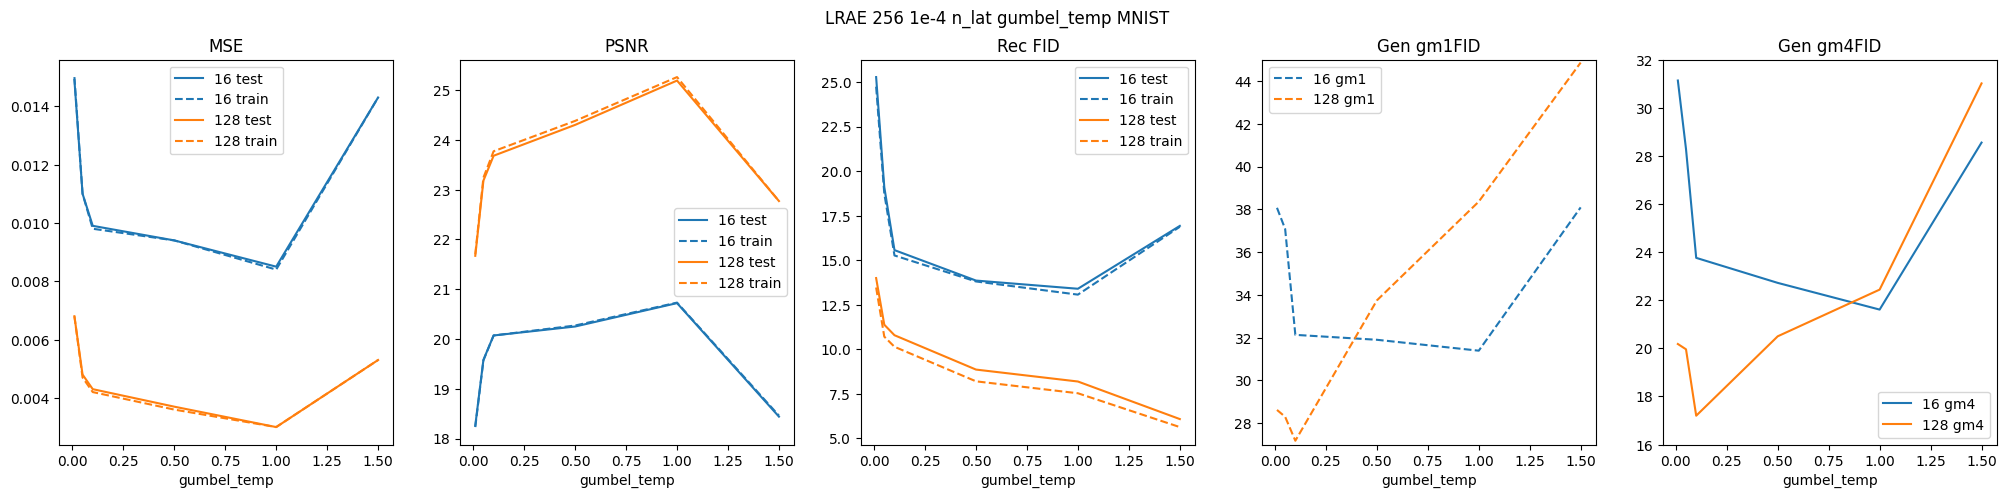

In [189]:
# PLOT 1

px, py = 1, 5

y_min_list = [None for i in range(py)]
y_max_list = [None for i in range(py)]



y_max_list[-2:] = [45, 32]
y_min_list[-2:] = [27, 16]


# y_max_list = [0.06, 30, 125, 120]
# y_min_list = [0, 12, 0, 10]

color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# suptitle = '[AE, IRMAE, VAE, LRAE] 256 1e-4 n_latent MNIST'
# suptitle = '[AE, IRMAE, VAE, LRAE] 256 1e-4 n_latent FMNIST'

plt.figure(figsize=[5*py, 5])
plt.tight_layout(w_pad=0.25)

for jj in range(len(data_dict_list)):
    data_dict = data_dict_list[jj]
    x_list = xx_list[jj]
    script_do_plot_2(color_list[jj])
    
plt.suptitle(suptitle)
    



In [ ]:
# main setup

# MSE
px, py = 1, 5

y_min_list = [0 for i in range(py)]
y_max_list = [0 for i in range(py)]

i_plot = 0

# Using chat GPT


### MNIST

In [74]:
suptitle = '[AE, IRMAE, VAE, LRAE] 256 1e-4 n_latent MNIST'

data_dict_list = []
xx_list = []


############### AE 
model_type = 'AE  256 1e-4 n_latent'
#  Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128]

# Mean epoch time
mean_epoch_time = [13.8, 12.9, 13.4, 13.8, 13.9, 12.6, 13.6]

# MSE (Mean Squared Error)
mse = [[0.0399, 0.0392],
       [0.0310, 0.0299],
       [0.0168, 0.0164],
       [0.0092, 0.0088],
       [0.0034, 0.0033],
       [0.0022, 0.0022],
       [0.0010, 0.0010]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[13.99, 14.06],
        [15.09, 15.24],
        [17.75, 17.85],
        [20.36, 20.53],
        [24.66, 24.88],
        [26.54, 26.66],
        [29.96, 29.98]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[118.35, 116.39],
           [72.55, 71.15],
           [31.36, 30.76],
           [13.75, 13.19],
           [8.11, 7.62],
           [7.64, 7.23],
           [5.83, 5.38]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [123.11, 89.59, 45.69, 34.31, 41.10, 60.29, 72.70]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [116.34, 74.75, 36.10, 20.57, 23.86, 36.80, 46.44]



data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]
###############




############### IRMAE
model_type = 'IRMAE  256 1e-4 n_latent'

#  Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128]

# Mean epoch time
mean_epoch_time = [13.0, 13.0, 11.7, 12.7, 12.6, 13.4, 13.3]

# MSE (Mean Squared Error)
mse = [[0.0396, 0.0392],
       [0.0569, 0.0566],
       [0.0172, 0.0168],
       [0.0114, 0.0109],
       [0.0071, 0.0065],
       [0.0053, 0.0047],
       [0.0063, 0.0054]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[14.02, 14.06],
        [12.45, 12.47],
        [17.64, 17.75],
        [19.42, 19.64],
        [21.50, 21.87],
        [22.79, 23.32],
        [22.00, 22.66]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[116.53, 114.90],
           [219.91, 218.43],
           [33.58, 32.48],
           [17.86, 17.34],
           [11.20, 10.50],
           [10.27, 9.63],
           [9.92, 9.28]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [111.88, 218.32, 46.87, 43.92, 30.37, 22.72, 25.02]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [115.08, 218.32, 38.83, 25.40, 18.60, 14.11, 14.18]



data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]
###############




############### VAE
model_type = 'VAE  256 1e-4 n_latent'
# Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128]

# Mean epoch time
mean_epoch_time = [13.2, 14.3, 11.5, 13.6, 12.0, 13.3, 12.9]

# MSE (Mean Squared Error)
mse = [[0.0443, 0.0439],
       [0.0369, 0.0365],
       [0.0339, 0.0337],
       [0.0167, 0.0166],
       [0.0103, 0.0101],
       [0.0063, 0.0061],
       [0.0042, 0.0040]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[13.54, 13.57],
        [14.33, 14.37],
        [14.70, 14.72],
        [17.78, 17.81],
        [19.89, 19.97],
        [22.03, 22.14],
        [23.78, 23.96]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[112.89, 110.21],
           [76.56, 74.24],
           [70.91, 69.00],
           [24.14, 23.63],
           [12.60, 12.26],
           [9.89, 9.18],
           [8.93, 8.24]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [108.04, 74.59, 71.63, 36.02, 31.42, 31.83, 33.94]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [109.31, 74.66, 69.68, 30.34, 22.53, 20.06, 19.72]



data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]
##################




################## LRAE
model_type = 'LRAE  256 1e-4 n_latent'
# Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128]

# Mean epoch time
mean_epoch_time = [14.5, 12.6, 11.7, 15.3, 13.7, 14.8, 15.7]

# MSE (Mean Squared Error)
mse = [[0.0372, 0.0371],
       [0.0272, 0.0271],
       [0.0162, 0.0161],
       [0.0094, 0.0094],
       [0.0063, 0.0062],
       [0.0048, 0.0047],
       [0.0037, 0.0036]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[14.29, 14.31],
        [15.65, 15.67],
        [17.92, 17.93],
        [20.25, 20.28],
        [22.04, 22.07],
        [23.18, 23.25],
        [24.36, 24.42]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[89.14, 87.14],
           [53.87, 52.68],
           [25.09, 24.84],
           [14.12, 13.78],
           [10.36, 9.86],
           [9.20, 8.57],
           [8.67, 8.13]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [84.57, 53.22, 35.50, 31.90, 32.41, 34.28, 33.04]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [86.19, 52.44, 29.91, 23.77, 21.93, 22.49, 20.13]


data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]


# ##################




# data_dict = {}
# data_dict['MSE_test'] = np.asarray(mse)[:,0].tolist()
# data_dict['MSE_train'] = np.asarray(mse)[:,1].tolist()
# data_dict['PSNR_test'] = np.asarray(psnr)[:,0].tolist()
# data_dict['PSNR_train'] = np.asarray(psnr)[:,1].tolist()
# data_dict['Rec FID_test'] = np.asarray(rec_fid)[:,0].tolist()
# data_dict['Rec FID_train'] = np.asarray(rec_fid)[:,1].tolist()
# data_dict['FID gm1'] = fid_gm1
# data_dict['FID gm4'] = fid_gm4
# data_dict['Mean epoch time'] = mean_epoch_time

# x_list = dimensions


### FMNIST


In [4]:
suptitle = '[AE, IRMAE, VAE, LRAE] 256 1e-4 n_latent FMNIST'

data_dict_list = []
xx_list = []
############### AE 
model_type = 'AE  256 1e-4 n_latent 100 epoch'


### from GPT
# Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Mean epoch time
mean_epoch_time = [12.0, 12.9, 11.3, 12.1, 13.2, 14.7, 11.2, 11.9, 11.2, 12.1]

# MSE (Mean Squared Error)
mse = [[0.0204, 0.0200],
       [0.0149, 0.0145],
       [0.0117, 0.0115],
       [0.0083, 0.0081],
       [0.0055, 0.0053],
       [0.0044, 0.0043],
       [0.0031, 0.0031],
       [0.0021, 0.0020],
       [0.0014, 0.0013],
       [0.0015, 0.0014]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[16.91, 16.99],
        [18.26, 18.37],
        [19.31, 19.39],
        [20.81, 20.92],
        [22.61, 22.75],
        [23.58, 23.69],
        [25.04, 25.15],
        [26.83, 26.97],
        [28.57, 28.80],
        [28.28, 28.48]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[118.22, 117.67],
           [73.08, 72.32],
           [62.39, 61.35],
           [39.63, 38.35],
           [28.32, 26.93],
           [23.98, 22.63],
           [16.13, 14.88],
           [9.68, 8.51],
           [5.65, 4.60],
           [5.29, 4.32]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [133.52, 85.29, 96.49, 82.87, 73.11, 70.82, 75.22, 82.04, 92.86, 99.09]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [116.44, 73.21, 70.30, 48.72, 38.25, 41.20, 38.38, 42.80, 46.63, 50.80]

####



data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]
###############




############### IRMAE
model_type = 'IRMAE  256 1e-4 n_latent'

### from GPT
# Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Mean epoch time
mean_epoch_time = [14.9, 13.5, 14.1, 13.3, 14.2, 15.0, 16.2, 12.5, 11.8, 12.1]

# MSE (Mean Squared Error)
mse = [[0.0297, 0.0294],
       [0.0203, 0.0202],
       [0.0122, 0.0120],
       [0.0094, 0.0092],
       [0.0080, 0.0078],
       [0.0067, 0.0065],
       [0.0066, 0.0062],
       [0.0067, 0.0063],
       [0.0085, 0.0078],
       [0.0086, 0.0080]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[15.28, 15.31],
        [16.92, 16.95],
        [19.15, 19.22],
        [20.26, 20.35],
        [20.96, 21.08],
        [21.75, 21.90],
        [21.82, 22.05],
        [21.77, 21.99],
        [20.72, 21.08],
        [20.65, 20.96]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[154.86, 154.87],
           [111.03, 110.76],
           [62.39, 61.35],
           [46.27, 45.05],
           [40.98, 39.63],
           [33.71, 32.33],
           [29.53, 28.13],
           [31.96, 30.60],
           [35.11, 33.51],
           [41.82, 40.32]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [162.27, 115.05, 88.87, 72.57, 63.17, 49.43, 59.00, 59.89, 49.45, 74.42]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [156.34, 110.81, 62.67, 47.63, 42.11, 35.46, 34.11, 37.41, 41.65, 54.57]


####



data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]
###############




############### VAE
model_type = 'VAE  256 1e-4 n_latent'

### from GPT
# Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Mean epoch time
mean_epoch_time = [11.4, 10.4, 10.8, 10.7, 12.2, 12.5, 11.5, 12.5, 13.8, 14.6]

# MSE (Mean Squared Error)
mse = [[0.0360, 0.0360],
       [0.0320, 0.0322],
       [0.0204, 0.0202],
       [0.0149, 0.0145],
       [0.0117, 0.0115],
       [0.0083, 0.0081],
       [0.0063, 0.0061],
       [0.0055, 0.0053],
       [0.0080, 0.0078],
       [0.0086, 0.0080]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[14.44, 14.44],
        [14.95, 14.92],
        [15.28, 15.31],
        [16.92, 16.95],
        [19.15, 19.22],
        [20.26, 20.35],
        [21.82, 22.05],
        [22.61, 22.75],
        [20.72, 21.08],
        [20.65, 20.96]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[145.59, 145.57],
           [111.03, 110.76],
           [62.96, 61.73],
           [46.27, 45.05],
           [40.98, 39.63],
           [33.71, 32.33],
           [29.53, 28.13],
           [31.96, 30.60],
           [35.11, 33.51],
           [41.82, 40.32]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [162.27, 115.05, 88.87, 72.57, 63.17, 49.43, 59.00, 59.89, 49.45, 74.42]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [156.34, 110.81, 62.67, 48.72, 42.11, 35.46, 34.11, 37.41, 41.65, 54.57]



####



data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]
##################




################## LRAE
model_type = 'LRAE  256 1e-4 n_latent'

### from GPT
# Number of dimensions (sorted)
dimensions = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Mean epoch time
mean_epoch_time = [14.9, 13.5, 14.1, 13.3, 14.2, 15.0, 16.2, 12.5, 11.8, 12.1]

# MSE (Mean Squared Error)
mse = [[0.0297, 0.0294],
       [0.0203, 0.0202],
       [0.0122, 0.0120],
       [0.0094, 0.0092],
       [0.0080, 0.0078],
       [0.0067, 0.0065],
       [0.0066, 0.0062],
       [0.0067, 0.0063],
       [0.0085, 0.0078],
       [0.0086, 0.0080]]

# PSNR (Peak Signal-to-Noise Ratio)
psnr = [[15.28, 15.31],
        [16.92, 16.95],
        [19.15, 19.22],
        [20.26, 20.35],
        [20.96, 21.08],
        [21.75, 21.90],
        [21.82, 22.05],
        [21.77, 21.99],
        [20.72, 21.08],
        [20.65, 20.96]]

# Rec FID (Reconstructed Fréchet Inception Distance)
rec_fid = [[154.86, 154.87],
           [111.03, 110.76],
           [62.96, 61.73],
           [46.27, 45.05],
           [40.98, 39.63],
           [33.71, 32.33],
           [29.53, 28.13],
           [31.96, 30.60],
           [35.11, 33.51],
           [41.82, 40.32]]

# FID gm1 (FID using the Gaussian Mixture Model 1)
fid_gm1 = [162.27, 115.05, 88.87, 72.57, 63.17, 49.43, 59.00, 59.89, 49.45, 74.42]

# FID gm4 (FID using the Gaussian Mixture Model 4)
fid_gm4 = [156.34, 110.81, 62.67, 48.72, 42.11, 35.46, 34.11, 37.41, 41.65, 54.57]


####

data_dict_, x_list = form_data_from_GPT(model_type, dimensions, mse, psnr, rec_fid,fid_gm1, fid_gm4, mean_epoch_time)
data_dict_list +=[data_dict_]
xx_list +=[x_list]


# ##################




In [64]:
for key in data_dict.keys():
    print(data_dict[key] == data_dict1[key] )


False
False
False
False
False
False
False
False
False


In [62]:
data_dict1 = data_dict

In [ ]:
'MSE_test': [0.0399, 0.031, 0.0168, 0.0092, 0.0034, 0.0022, 0.001],
 'MSE_train': [0.0392, 0.0299, 0.0164, 0.0088, 0.0033, 0.0022, 0.001],
 'PSNR_test': [13.99, 15.09, 17.75, 20.36, 24.66, 26.54, 29.96],
 'PSNR_train': [14.06, 15.24, 17.85, 20.53, 24.88, 26.66, 29.98],
 'Rec FID_test': [118.35, 72.55, 31.36, 13.75, 8.11, 7.64, 5.83],
 'Rec FID_train': [116.39, 71.15, 30.76, 13.19, 7.62, 7.23, 5.38],
 'FID gm1': [123.11, 89.59, 45.69, 34.31, 41.1, 60.29, 72.7],
 'FID gm4': [116.34, 74.75, 36.1, 20.57, 23.86, 36.8, 46.44],
 'Mean epoch time': [13.8, 12.9, 13.4, 13.8, 13.9, 12.6, 13.0]

# others

In [117]:

b = {1:1, 2:2} | {3:3}
b

{1: 1, 2: 2, 3: 3}